In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mne
mne.set_log_level('error')  # reduce extraneous MNE output
import pickle
import pingouin as pg

### Step 1. Read the data

In [2]:
eoi = ['EYEOPEN', 'IN', 'QF', 'SPEAK', 'TYPE', 'READ', 'LISTEN', ]
conditions = ['IN', 'QF', 'QS', 'RJ', 'READ', 'LISTEN', 'SPEAK', 'TYPE']
baseline = ['EYEOPEN', 'EYECLOSE']
info_cols = ['PID', 'Topic', 'stage']
chs = ['AF3','F7','F3','FC5','T7','P7','O1','O2','P8','T8','FC6','F4','F8','AF4',]
bands = ['theta', 'alpha', 'beta', 'lowgamma']
bands_names = ['Theta (4-8Hz)', 'Alpha (8-13Hz)', 'Beta (13-25Hz)', 'Lowgamma (25-40Hz)']

Format the data

In [3]:
data = pd.read_csv('data for analysis/EEG_features(2-1).csv')
data

,bandPower:PSD_norm_AF3_alpha,bandPower:PSD_norm_AF3_beta,bandPower:PSD_norm_AF3_lowgamma,bandPower:PSD_norm_AF3_theta,bandPower:PSD_norm_F7_alpha,bandPower:PSD_norm_F7_beta,bandPower:PSD_norm_F7_lowgamma,bandPower:PSD_norm_F7_theta,bandPower:PSD_norm_F3_alpha,bandPower:PSD_norm_F3_beta,...,bandPower:PSD_norm_F8_beta,bandPower:PSD_norm_F8_lowgamma,bandPower:PSD_norm_F8_theta,bandPower:PSD_norm_AF4_alpha,bandPower:PSD_norm_AF4_beta,bandPower:PSD_norm_AF4_lowgamma,bandPower:PSD_norm_AF4_theta,PID,Topic,stage
0,0.046733,0.106394,0.186343,0.087542,0.045583,0.095800,0.291603,0.089105,0.044715,0.120953,...,0.086376,0.219286,0.094154,0.104539,0.085072,0.088404,0.137242,PA29,355.0,READ
1,0.046733,0.106394,0.186343,0.087542,0.045583,0.095800,0.291603,0.089105,0.044715,0.120953,...,0.086376,0.219286,0.094154,0.104539,0.085072,0.088404,0.137242,PA29,355.0,RJ
2,0.057236,0.105364,0.157804,0.088440,0.046872,0.064404,0.082248,0.092785,0.057515,0.069588,...,0.073336,0.081051,0.114039,0.047755,0.095301,0.140273,0.089626,PA13,355.0,RJ
3,0.057236,0.105364,0.157804,0.088440,0.046872,0.064404,0.082248,0.092785,0.057515,0.069588,...,0.073336,0.081051,0.114039,0.047755,0.095301,0.140273,0.089626,PA13,355.0,READ
4,0.082368,0.133534,0.150510,0.064888,0.120996,0.129865,0.118865,0.081976,0.108607,0.120123,...,0.131197,0.141312,0.076277,0.138766,0.132301,0.145254,0.066280,PA21,708.0,RJ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,0.030065,0.095963,0.248428,0.014380,0.069125,0.131051,0.110943,0.044404,0.049970,0.151572,...,0.101647,0.129344,0.051564,0.023620,0.077157,0.228645,0.015478,PA32,743.0,SPEAK
1446,0.013908,0.057418,0.115849,0.056206,0.073639,0.265079,0.227268,0.047440,0.085512,0.094775,...,0.232172,0.286858,0.041058,0.020400,0.066524,0.134562,0.059334,PA32,708.0,SPEAK
1447,0.042634,0.053396,0.135511,0.037046,0.032924,0.041164,0.052402,0.088297,0.058946,0.094556,...,0.071894,0.128669,0.038590,0.013173,0.046531,0.076543,0.032200,PA5,355.0,SPEAK
1448,0.017262,0.046712,0.226808,0.044165,0.055473,0.130165,0.186754,0.055718,0.053912,0.108421,...,0.094278,0.169836,0.043660,0.025267,0.065953,0.205743,0.075844,PA32,355.0,SPEAK


In [4]:
staistic = data[data.stage.isin(eoi)][['PID', 'Topic', 'stage']].value_counts().reset_index()
staistic[['count', 'stage']].groupby('stage').sum()

,count
stage,
EYEOPEN,20
IN,235
LISTEN,117
QF,235
READ,118
SPEAK,116
TYPE,119


In [5]:
data = data[data.stage.isin(eoi)]
print(data.shape)
print(data[data.stage == 'IN'].shape,data[data.stage == 'EYEOPEN'].shape)
data[~data.stage.isin(['IN', 'QF', 'EYEOPEN'])][['PID', 'Topic', 'stage']].groupby(['PID', 'Topic']).aggregate(lambda x: '+'.join(x)).reset_index(drop=True).value_counts()

(960, 59)
(235, 59) (20, 59)


stage       
READ+TYPE       59
LISTEN+SPEAK    58
LISTEN+TYPE     58
READ+SPEAK      58
TYPE+LISTEN      1
TYPE+READ        1
Name: count, dtype: int64

In [6]:
## format the data
info = ['PID', 'stage', 'Topic']
features = [c for c in data.columns if c.__contains__('norm') and (c.__contains__(bands[0]) \
            or c.__contains__(bands[1]) or c.__contains__(bands[2]) or c.__contains__(bands[3]))]
print(len(features), 'EEG features')
data = data[features+info]
data.rename(columns={f: '_'.join(f.split('_')[-2:]) for f in features}, inplace=True)
data.head(3)

56 EEG features


,AF3_alpha,AF3_beta,AF3_lowgamma,AF3_theta,F7_alpha,F7_beta,F7_lowgamma,F7_theta,F3_alpha,F3_beta,...,F8_beta,F8_lowgamma,F8_theta,AF4_alpha,AF4_beta,AF4_lowgamma,AF4_theta,PID,stage,Topic
0,0.046733,0.106394,0.186343,0.087542,0.045583,0.095800,0.291603,0.089105,0.044715,0.120953,...,0.086376,0.219286,0.094154,0.104539,0.085072,0.088404,0.137242,PA29,READ,355.0
3,0.057236,0.105364,0.157804,0.088440,0.046872,0.064404,0.082248,0.092785,0.057515,0.069588,...,0.073336,0.081051,0.114039,0.047755,0.095301,0.140273,0.089626,PA13,READ,355.0
5,0.082368,0.133534,0.150510,0.064888,0.120996,0.129865,0.118865,0.081976,0.108607,0.120123,...,0.131197,0.141312,0.076277,0.138766,0.132301,0.145254,0.066280,PA21,READ,708.0


In [7]:
freq_features = {}
for fq in bands:
    freq_features[fq] = [c for c in data.columns if c.__contains__(fq) and c.split('_')[0] in chs]
print('Get the feature names for each band:', freq_features)

Get the feature names for each band: {'theta': ['AF3_theta', 'F7_theta', 'F3_theta', 'FC5_theta', 'T7_theta', 'P7_theta', 'O1_theta', 'O2_theta', 'P8_theta', 'T8_theta', 'FC6_theta', 'F4_theta', 'F8_theta', 'AF4_theta'], 'alpha': ['AF3_alpha', 'F7_alpha', 'F3_alpha', 'FC5_alpha', 'T7_alpha', 'P7_alpha', 'O1_alpha', 'O2_alpha', 'P8_alpha', 'T8_alpha', 'FC6_alpha', 'F4_alpha', 'F8_alpha', 'AF4_alpha'], 'beta': ['AF3_beta', 'F7_beta', 'F3_beta', 'FC5_beta', 'T7_beta', 'P7_beta', 'O1_beta', 'O2_beta', 'P8_beta', 'T8_beta', 'FC6_beta', 'F4_beta', 'F8_beta', 'AF4_beta'], 'lowgamma': ['AF3_lowgamma', 'F7_lowgamma', 'F3_lowgamma', 'FC5_lowgamma', 'T7_lowgamma', 'P7_lowgamma', 'O1_lowgamma', 'O2_lowgamma', 'P8_lowgamma', 'T8_lowgamma', 'FC6_lowgamma', 'F4_lowgamma', 'F8_lowgamma', 'AF4_lowgamma']}


### Step 2. Conduct Statistical Testing

In [8]:
for (band, ffs) in freq_features.items():
    tcnt, fcnt = 0,0
    for depvar in ffs:
        ch = depvar.split('_')[-2]
        stats = pg.normality(data=data[data.stage.isin(eoi)], dv=depvar, group='stage')
        if stats['normal'].values[0]: tcnt +=1
        else: fcnt += 1
    print(f'Check Normality for band [{band}]: {tcnt/(tcnt+fcnt):.2f}, {tcnt} channels normal distribution, {fcnt} not.')
print('-'*20)
for (band, ffs) in freq_features.items():
    tcnt, fcnt = 0,0
    for depvar in ffs:
        ch = depvar.split('_')[-2]
        stats = pg.homoscedasticity(data=data[data.stage.isin(eoi)], dv=depvar, group='stage')
        if stats['equal_var'].values[0]: tcnt +=1
        else: fcnt += 1
    print(f'Check Homoscedasticity for band [{band}]: {tcnt/(tcnt+fcnt):.2f}, {tcnt} channels equal variance, {fcnt} have not.')

Check Normality for band [theta]: 0.79, 11 channels normal distribution, 3 not.
Check Normality for band [alpha]: 0.14, 2 channels normal distribution, 12 not.
Check Normality for band [beta]: 0.50, 7 channels normal distribution, 7 not.
Check Normality for band [lowgamma]: 0.29, 4 channels normal distribution, 10 not.
--------------------
Check Homoscedasticity for band [theta]: 0.14, 2 channels equal variance, 12 have not.
Check Homoscedasticity for band [alpha]: 0.00, 0 channels equal variance, 14 have not.
Check Homoscedasticity for band [beta]: 0.50, 7 channels equal variance, 7 have not.
Check Homoscedasticity for band [lowgamma]: 0.57, 8 channels equal variance, 6 have not.


In [9]:
for (band, ffs) in freq_features.items():
    tcnt, fcnt = 0,0
    for depvar in ffs:
        ch = depvar.split('_')[-2]
        stats = pg.sphericity(data=data[data.stage.isin(eoi)], dv=depvar, within='stage', subject='PID')
        if stats.spher: tcnt +=1
        else: fcnt += 1
    print(f'Check sphericityity for band [{band}]: {tcnt} channels have sphericity property, {fcnt} have not.')

Check sphericityity for band [theta]: 14 channels have sphericity property, 0 have not.


/home/sl7/S3928927/miniconda3/envs/sensors/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d
/home/sl7/S3928927/miniconda3/envs/sensors/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d
/home/sl7/S3928927/miniconda3/envs/sensors/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d
/home/sl7/S3928927/miniconda3/envs/sensors/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig) / (eig.sum() / d) ** d
/home/sl7/S3928927/miniconda3/envs/sensors/lib/python3.11/site-packages/pingouin/distribution.py:1004: RuntimeWarning: divide by zero encountered in scalar divide
  W = np.prod(eig

Check sphericityity for band [alpha]: 14 channels have sphericity property, 0 have not.
Check sphericityity for band [beta]: 14 channels have sphericity property, 0 have not.
Check sphericityity for band [lowgamma]: 14 channels have sphericity property, 0 have not.


In [10]:
def compute_RMf(df, depvars, within, parametric=True):
    results = []
    for depvar in depvars:
        ch = depvar.split('_')[0]
        if not parametric:
            res = pg.friedman(data=df, dv=depvar, subject='PID', within=within, method='f')
        else:
            res = pg.rm_anova(data=df, dv=depvar, subject='PID', within=within,correction=True)
        res['ch'] = ch
        results.append(res)
    results = pd.concat(results)
    results.reset_index(drop=True, inplace=True)
    return results


def compute_pairwise(df, depvars, within, parametric=True):
    results = []
    for depvar in depvars:
        ch = depvar.split('_')[0]
        res = pg.pairwise_tests(data=df, dv=depvar, parametric=parametric, padjust='bonf',
                  subject='PID', within=within, correction=True)
        res['ch'] = ch
        results.append(res)
    results = pd.concat(results)
    results.reset_index(drop=True, inplace=True)
    return results

opath= 'Standard-10-20-Cap14.locs'
mont=mne.channels.read_custom_montage(opath)

### compute on the 6 stages + EYEOPEN

In [11]:
cond6 = eoi
print(cond6)
dd6 = data[data.stage.isin(cond6)]
print(dd6.stage.value_counts())

['EYEOPEN', 'IN', 'QF', 'SPEAK', 'TYPE', 'READ', 'LISTEN']
stage
IN         235
QF         235
TYPE       119
READ       118
LISTEN     117
SPEAK      116
EYEOPEN     20
Name: count, dtype: int64


In [12]:
fstats_stage = {}
for (band, ffs) in freq_features.items():
    res = compute_RMf(dd6, ffs, 'stage', False)
    fstats_stage[band] = res
print(fstats_stage['alpha'])    

pos_stage = {}
for key, val in fstats_stage.items():
    sen = val[val['p-unc'] < 0.001].ch.values
    pos_stage[key] = sen
print(pos_stage)

   Source         W  ddof1  ddof2          F         p-unc   ch
0   stage  0.313750    5.9  112.1   8.686703  1.086544e-07  AF3
1   stage  0.386071    5.9  112.1  11.948226  3.104972e-10   F7
2   stage  0.421964    5.9  112.1  13.869941  1.252096e-11   F3
3   stage  0.453929    5.9  112.1  15.793983  5.919402e-13  FC5
4   stage  0.548214    5.9  112.1  23.055336  2.054125e-17   T7
5   stage  0.630893    5.9  112.1  32.475568  3.220858e-22   P7
6   stage  0.601250    5.9  112.1  28.648903  2.232305e-20   O1
7   stage  0.446786    5.9  112.1  15.344739  1.190446e-12   O2
8   stage  0.552500    5.9  112.1  23.458101  1.221787e-17   P8
9   stage  0.606964    5.9  112.1  29.341663  1.011981e-20   T8
10  stage  0.422500    5.9  112.1  13.900433  1.191509e-11  FC6
11  stage  0.610357    5.9  112.1  29.762603  6.290897e-21   F4
12  stage  0.473214    5.9  112.1  17.067797  8.529794e-14   F8
13  stage  0.369107    5.9  112.1  11.116049  1.316044e-09  AF4
{'theta': array(['P7', 'O1', 'O2', 'P8',

In [13]:
stats_results = []
for k, d in fstats_stage.items():
    d['band'] = k
    stats_results.append(d)
stats_results = pd.concat(stats_results)
stats_results.to_csv('results/EEG_stats_results_6stages.csv', index=False)
stats_results

,Source,W,ddof1,ddof2,F,p-unc,ch,band
0,stage,0.088750,5.9,112.1,1.850480,9.686223e-02,AF3,theta
1,stage,0.119107,5.9,112.1,2.569025,2.343154e-02,F7,theta
2,stage,0.110714,5.9,112.1,2.365462,3.530657e-02,F3,theta
3,stage,0.037321,5.9,112.1,0.736598,6.190062e-01,FC5,theta
4,stage,0.176429,5.9,112.1,4.070252,1.059655e-03,T7,theta
5,stage,0.305714,5.9,112.1,8.366255,1.989266e-07,P7,theta
6,stage,0.281429,5.9,112.1,7.441352,1.174035e-06,O1,theta
7,stage,0.379107,5.9,112.1,11.601093,5.648383e-10,O2,theta
8,stage,0.247857,5.9,112.1,6.261159,1.204168e-05,P8,theta
9,stage,0.137679,5.9,112.1,3.033547,9.068180e-03,T8,theta


##### plot

In [14]:
vmax = max([f['F'].max() for f in fstats_stage.values()])
print(vmax)
vlim = (0, 35)

32.475568456700536


In [15]:
stats_results[stats_results.F == stats_results.F.max()]

,Source,W,ddof1,ddof2,F,p-unc,ch,band
5,stage,0.630893,5.9,112.1,32.475568,3.220858e-22,P7,alpha


In [16]:
fstats_stage['alpha']

,Source,W,ddof1,ddof2,F,p-unc,ch,band
0,stage,0.313750,5.9,112.1,8.686703,1.086544e-07,AF3,alpha
1,stage,0.386071,5.9,112.1,11.948226,3.104972e-10,F7,alpha
2,stage,0.421964,5.9,112.1,13.869941,1.252096e-11,F3,alpha
3,stage,0.453929,5.9,112.1,15.793983,5.919402e-13,FC5,alpha
4,stage,0.548214,5.9,112.1,23.055336,2.054125e-17,T7,alpha
5,stage,0.630893,5.9,112.1,32.475568,3.220858e-22,P7,alpha
6,stage,0.601250,5.9,112.1,28.648903,2.232305e-20,O1,alpha
7,stage,0.446786,5.9,112.1,15.344739,1.190446e-12,O2,alpha
8,stage,0.552500,5.9,112.1,23.458101,1.221787e-17,P8,alpha
9,stage,0.606964,5.9,112.1,29.341663,1.011981e-20,T8,alpha


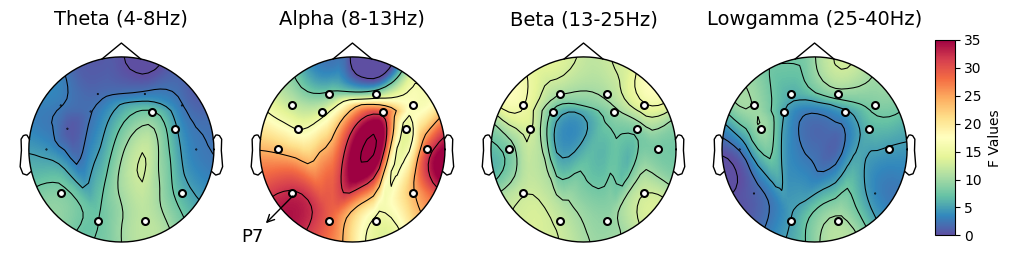

In [17]:
OUTPUT = 1

fig, axes = plt.subplots(1, 4, figsize=(10, 4), layout='constrained')

for n, (band, vals) in enumerate(fstats_stage.items()):
    info = mne.create_info(ch_names=list(vals.ch), sfreq=128, ch_types='eeg')
    info.set_montage(mont)
    f_values = np.array(vals['F'].values)
    highlight_channels = pos_stage[band]
    mask = np.array([ch in highlight_channels for ch in info['ch_names']])
    im, _ = mne.viz.plot_topomap(f_values, info, axes=axes[n], size=5, res=32,
                         show=False, sphere=0.12, sensors=True, contours=5, 
                         vlim=vlim, cmap='Spectral_r',
                        mask=mask, mask_params=dict(marker='o', markerfacecolor='white', markeredgewidth=1.5, markersize=5),)
    axes[n].set_title(bands_names[n],fontsize=14)

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), drawedges=False,
                    use_gridspec=True,
                    shrink=0.5,
                    orientation='vertical', pad=0.01, aspect=10, fraction=0.2)
cbar.set_label('F Values')

dig_positions = mont.get_positions()['ch_pos']
p7_position = dig_positions['P7']

axes[1].annotate(
    'P7',
    xy=(p7_position[0]+0.002, p7_position[1]-0.002), xycoords='data',
    xytext=(0, 0), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='<-'),
    fontsize=13, color='black'
)

if OUTPUT:
    plt.savefig(f'images/EEG_FRIEDMAN_topo(6-p.001).pdf', bbox_inches='tight')
plt.show()

### Posthoc

In [18]:
posthoc = {}
for (band, ffs) in freq_features.items():
    res = compute_pairwise(dd6, ffs, 'stage', False)
    posthoc[band] = res
res

posthoc['alpha']

,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges,ch
0,stage,EYEOPEN,IN,True,False,86.0,two-sided,0.498009,1.000000,bonf,-0.101985,AF3
1,stage,EYEOPEN,LISTEN,True,False,55.0,two-sided,0.063723,1.000000,bonf,-0.392808,AF3
2,stage,EYEOPEN,QF,True,False,53.0,two-sided,0.053169,1.000000,bonf,-0.388725,AF3
3,stage,EYEOPEN,READ,True,False,84.0,two-sided,0.452375,1.000000,bonf,-0.188895,AF3
4,stage,EYEOPEN,SPEAK,True,False,30.0,two-sided,0.003654,0.076744,bonf,0.666617,AF3
...,...,...,...,...,...,...,...,...,...,...,...,...
289,stage,QF,SPEAK,True,False,0.0,two-sided,0.000002,0.000040,bonf,0.800159,AF4
290,stage,QF,TYPE,True,False,9.0,two-sided,0.000063,0.001322,bonf,1.043041,AF4
291,stage,READ,SPEAK,True,False,20.0,two-sided,0.000708,0.014860,bonf,0.727591,AF4
292,stage,READ,TYPE,True,False,11.0,two-sided,0.000105,0.002203,bonf,1.035906,AF4


In [19]:
postdoc_results = []
for k, d in posthoc.items():
    d['band'] = k
    postdoc_results.append(d)
postdoc_results = pd.concat(postdoc_results)
postdoc_results

,Contrast,A,B,Paired,Parametric,W-val,alternative,p-unc,p-corr,p-adjust,hedges,ch,band
0,stage,EYEOPEN,IN,True,False,94.0,two-sided,0.701181,1.000000,bonf,-0.040550,AF3,theta
1,stage,EYEOPEN,LISTEN,True,False,89.0,two-sided,0.570597,1.000000,bonf,0.104484,AF3,theta
2,stage,EYEOPEN,QF,True,False,101.0,two-sided,0.898317,1.000000,bonf,0.057571,AF3,theta
3,stage,EYEOPEN,READ,True,False,85.0,two-sided,0.474905,1.000000,bonf,-0.120711,AF3,theta
4,stage,EYEOPEN,SPEAK,True,False,72.0,two-sided,0.230513,1.000000,bonf,0.323675,AF3,theta
...,...,...,...,...,...,...,...,...,...,...,...,...,...
289,stage,QF,SPEAK,True,False,14.0,two-sided,0.000210,0.004406,bonf,0.724372,AF4,lowgamma
290,stage,QF,TYPE,True,False,20.0,two-sided,0.000708,0.014860,bonf,0.762897,AF4,lowgamma
291,stage,READ,SPEAK,True,False,17.0,two-sided,0.000395,0.008291,bonf,0.712622,AF4,lowgamma
292,stage,READ,TYPE,True,False,24.0,two-sided,0.001432,0.030081,bonf,0.760865,AF4,lowgamma


In [20]:
postdoc_results.to_csv('results/EEG_postdoc_results_6stages.csv', index=False)

#### EYEOPEN VS IN VS RJ-READ

In [21]:
fstats3 = {}
for (band, ffs) in freq_features.items():
    res = compute_RMf(data[data.stage.isin(['EYEOPEN', 'IN', 'READ'])], \
                      ffs, 'stage', False)
    fstats3[band] = res
print(fstats3['alpha'])    

pos3 = {}
for key, val in fstats3.items():
    sen = val[val['p-unc'] < 0.001].ch.values
    pos3[key] = sen
print(pos3)

   Source       W  ddof1  ddof2          F     p-unc   ch
0   stage  0.0525    1.9   36.1   1.052770  0.356366  AF3
1   stage  0.0225    1.9   36.1   0.437340  0.639033   F7
2   stage  0.1075    1.9   36.1   2.288515  0.118303   F3
3   stage  0.0475    1.9   36.1   0.947507  0.393011  FC5
4   stage  0.1675    1.9   36.1   3.822823  0.033131   T7
5   stage  0.1975    1.9   36.1   4.676012  0.016970   P7
6   stage  0.2100    1.9   36.1   5.050633  0.012751   O1
7   stage  0.1425    1.9   36.1   3.157434  0.056870   O2
8   stage  0.3175    1.9   36.1   8.838828  0.000894   P8
9   stage  0.3775    1.9   36.1  11.522088  0.000169   T8
10  stage  0.0625    1.9   36.1   1.266667  0.292717  FC6
11  stage  0.2775    1.9   36.1   7.297578  0.002514   F4
12  stage  0.0175    1.9   36.1   0.338422  0.704224   F8
13  stage  0.0400    1.9   36.1   0.791667  0.454922  AF4
{'theta': array(['O2'], dtype=object), 'alpha': array(['P8', 'T8'], dtype=object), 'beta': array([], dtype=object), 'lowgamma': ar

In [22]:
stats3 = []
for k, d in fstats3.items():
    d['band'] = k
    stats3.append(d)
stats3 = pd.concat(stats3)
stats3.to_csv('results/EEG_stats_results_ECINREAD.csv', index=False)

In [23]:
vmax = max([f['F'].max() for f in fstats3.values()])
vmin = min([f['F'].min() for f in fstats3.values()])
print(vmax, vmin)
vlim = (0, 15)

11.522088353413654 0.0


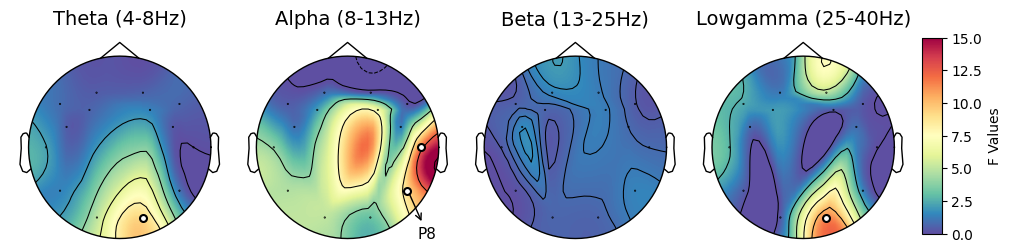

In [24]:
OUTPUT = 1

fig, axes = plt.subplots(1, 4, figsize=(10, 4), layout='constrained')

for n, (band, vals) in enumerate(fstats3.items()):
    info = mne.create_info(ch_names=list(vals.ch), sfreq=128, ch_types='eeg')
    info.set_montage(mont)
    f_values = np.array(vals['F'].values)
    highlight_channels = pos3[band]
    mask = np.array([ch in highlight_channels for ch in info['ch_names']])
    im, _ = mne.viz.plot_topomap(f_values, info, axes=axes[n], size=5, res=32,
                         show=False, sphere=0.12, sensors=True, contours=5, 
                         vlim=vlim, cmap='Spectral_r',
                        mask=mask, mask_params=dict(marker='o', markerfacecolor='white', markeredgewidth=1.5, markersize=5),)
    axes[n].set_title(bands_names[n],fontsize=14)

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), drawedges=False,
                    use_gridspec=True,
                    shrink=0.5,
                    orientation='vertical', pad=0.01, aspect=10, fraction=0.2)
cbar.set_label('F Values')
 
dig_positions = mont.get_positions()['ch_pos']
p8_position = dig_positions['P8']
axes[1].annotate(
    'P8',
    xy=(p8_position[0]+0.003, p8_position[1]-0.002), xycoords='data',
    xytext=(0.82, 0), textcoords='axes fraction',
    arrowprops=dict(facecolor='black', arrowstyle='<-'),
    fontsize=11, color='black'
)

if OUTPUT:
    plt.savefig('images/EEG_EOINREAD(p.001)_4topo.pdf', bbox_inches='tight')
plt.show()

#### READ VS LISTEN

In [25]:
pos1 = {}
ss1 = {}
for key, val in posthoc.items():
    val = val[((val['A'] == 'LISTEN') & (val['B'] == 'READ')) | \
    ((val['B'] == 'LISTEN') & (val['A'] == 'READ')) ]
    sen = val[val['p-corr'] < 0.05].ch.values
    pos1[key] = sen
    ss1[key] = val
print(pos1)
ss1

{'theta': array(['P7', 'O1', 'O2', 'F4'], dtype=object), 'alpha': array(['P7', 'O1', 'O2'], dtype=object), 'beta': array([], dtype=object), 'lowgamma': array([], dtype=object)}


{'theta':     Contrast       A     B  Paired  Parametric  W-val alternative     p-unc  \
 12     stage  LISTEN  READ    True       False   41.0   two-sided  0.015312   
 33     stage  LISTEN  READ    True       False   28.0   two-sided  0.002712   
 54     stage  LISTEN  READ    True       False   34.0   two-sided  0.006390   
 75     stage  LISTEN  READ    True       False   84.0   two-sided  0.452375   
 96     stage  LISTEN  READ    True       False   53.0   two-sided  0.053169   
 117    stage  LISTEN  READ    True       False   22.0   two-sided  0.001017   
 138    stage  LISTEN  READ    True       False    0.0   two-sided  0.000002   
 159    stage  LISTEN  READ    True       False    0.0   two-sided  0.000002   
 180    stage  LISTEN  READ    True       False   29.0   two-sided  0.003153   
 201    stage  LISTEN  READ    True       False   68.0   two-sided  0.176853   
 222    stage  LISTEN  READ    True       False   41.0   two-sided  0.015312   
 243    stage  LISTEN  READ    

#### SPEAK VS TYPE

In [26]:
pos2 = {}
ss2 = {}
for key, val in posthoc.items():
    val = val[((val['A'] == 'SPEAK') & (val['B'] == 'TYPE')) | \
    ((val['B'] == 'SPEAK') & (val['A'] == 'TYPE')) ]
    sen = val[val['p-corr'] < 0.05].ch.values
    pos2[key] = sen
    ss2[key] = val
print(pos2)
ss2

{'theta': array([], dtype=object), 'alpha': array([], dtype=object), 'beta': array([], dtype=object), 'lowgamma': array([], dtype=object)}


{'theta':     Contrast      A     B  Paired  Parametric  W-val alternative     p-unc  \
 20     stage  SPEAK  TYPE    True       False   99.0   two-sided  0.840822   
 41     stage  SPEAK  TYPE    True       False   95.0   two-sided  0.728506   
 62     stage  SPEAK  TYPE    True       False   92.0   two-sided  0.647655   
 83     stage  SPEAK  TYPE    True       False   68.0   two-sided  0.176853   
 104    stage  SPEAK  TYPE    True       False   55.0   two-sided  0.063723   
 125    stage  SPEAK  TYPE    True       False   42.0   two-sided  0.017181   
 146    stage  SPEAK  TYPE    True       False   66.0   two-sided  0.153646   
 167    stage  SPEAK  TYPE    True       False   42.0   two-sided  0.017181   
 188    stage  SPEAK  TYPE    True       False   42.0   two-sided  0.017181   
 209    stage  SPEAK  TYPE    True       False   55.0   two-sided  0.063723   
 230    stage  SPEAK  TYPE    True       False   41.0   two-sided  0.015312   
 251    stage  SPEAK  TYPE    True       Fa

In [27]:
vmax = max(max([f['W-val'].max() for f in ss1.values()]), \
           max([f['W-val'].max() for f in ss2.values()]))
vmin = min(min([f['W-val'].min() for f in ss1.values()]), \
           min([f['W-val'].min() for f in ss2.values()]))
print(vmin, vmax)
vlim = (0, 105)

0.0 104.0


PLOT FOR BOTH

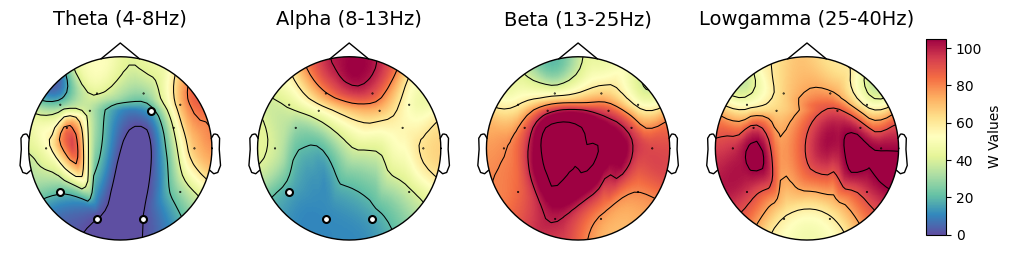

In [28]:
OUTPUT = 1

fig, axes = plt.subplots(1, 4, figsize=(10, 4), layout='constrained')

for n, (band, vals) in enumerate(ss1.items()):
    info = mne.create_info(ch_names=list(vals.ch), sfreq=128, ch_types='eeg')
    info.set_montage(mont)
    f_values = np.array(vals['W-val'].values)
    highlight_channels = pos1[band]
    mask = np.array([ch in highlight_channels for ch in info['ch_names']])
    im, _ = mne.viz.plot_topomap(f_values, info, axes=axes[n], size=5, res=32,
                         show=False, sphere=0.12, sensors=True, contours=5, 
                         vlim=vlim, cmap='Spectral_r',
                        mask=mask, mask_params=dict(marker='o', markerfacecolor='white', markeredgewidth=1.5, markersize=5),)
    axes[n].set_title(bands_names[n],fontsize=14)

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), drawedges=False,
                    use_gridspec=True,
                    shrink=0.5,
                    orientation='vertical', pad=0.01, aspect=10, fraction=0.2)
cbar.set_label('W Values')

# dig_positions = mont.get_positions()['ch_pos']
# p8_position = dig_positions['P8']
# axes[1].annotate(
#     'P8',
#     xy=(p8_position[0]+0.003, p8_position[1]-0.002), xycoords='data',
#     xytext=(0.82, 0), textcoords='axes fraction',
#     arrowprops=dict(facecolor='black', arrowstyle='<-'),
#     fontsize=11, color='black'
# )

if OUTPUT:
    plt.savefig('images/EEG_READLISTEN(p.05)_4topo.pdf', bbox_inches='tight')
plt.show()

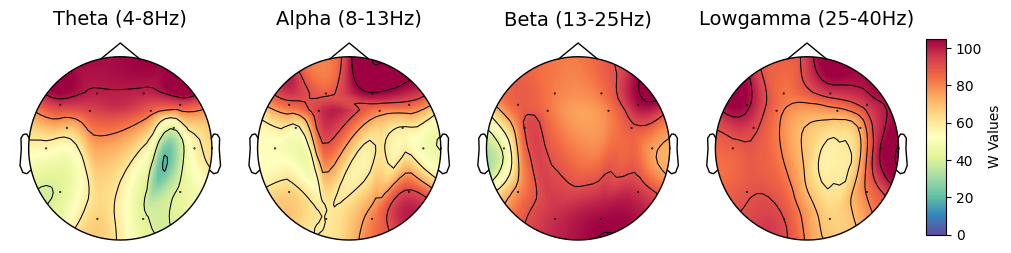

In [29]:
OUTPUT = 1

fig, axes = plt.subplots(1, 4, figsize=(10, 4), layout='constrained')

for n, (band, vals) in enumerate(ss2.items()):
    info = mne.create_info(ch_names=list(vals.ch), sfreq=128, ch_types='eeg')
    info.set_montage(mont)
    f_values = np.array(vals['W-val'].values)
    highlight_channels = pos2[band]
    mask = np.array([ch in highlight_channels for ch in info['ch_names']])
    im, _ = mne.viz.plot_topomap(f_values, info, axes=axes[n], size=5, res=32,
                         show=False, sphere=0.12, sensors=True, contours=5, 
                         vlim=vlim, cmap='Spectral_r',
                        mask=mask, mask_params=dict(marker='o', markerfacecolor='white', markeredgewidth=1.5, markersize=5),)
    axes[n].set_title(bands_names[n],fontsize=14)

cbar = fig.colorbar(im, ax=axes.ravel().tolist(), drawedges=False,
                    use_gridspec=True,
                    shrink=0.5,
                    orientation='vertical', pad=0.01, aspect=10, fraction=0.2)
cbar.set_label('W Values')

if OUTPUT:
    plt.savefig(f'images/EEG_SPEAKTYPE(p.05)_4topo.pdf', bbox_inches='tight')
plt.show()